<a href="https://colab.research.google.com/github/BangachevKiril/RepresentationLearningTheory/blob/main/SigLIPModalityGapImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

This code provides experiments for the modality gap in SigLIP following the [paper by Kiril Bangachev, Guy Bresler, Iliyas Noman, Yury Polyansnkiy](??)

The code is adpted from a [Notebook on SigLIP2 Experiments by Google DeepMind](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/image_text/SigLIP_demo.ipynb)

As the experiment does not require a massive amount of data, we choose to work with a subset of the ImageNET dataset. Specifically, we work with the [ILSVRC2012 validation dataset](https://image-net.org/challenges/LSVRC/2012/2012-downloads.php) which has 50 000 labelled images.

In [1]:
#@markdown # Environment setup
#@markdown **IMPORTANT NOTE**: Modern jax (>0.4) does not support the Colab TPU
#@markdown anymore, so don't select TPU runtime here. CPU and GPU work and are both fast enough.

# Install the right jax version for TPU/GPU/CPU
import os
if 'COLAB_TPU_ADDR' in os.environ:
  raise "TPU colab not supported."
elif 'NVIDIA_PRODUCT_NAME' in os.environ:
  !nvidia-smi
import jax
jax.devices()


# Get latest version of big_vision codebase.
!git clone --quiet --branch=main --depth=1 https://github.com/google-research/big_vision
!cd big_vision && git pull --rebase --quiet
!pip -q install -r big_vision/big_vision/requirements.txt
# Gives us ~2x faster gsutil cp to get the model checkpoints.
!pip3 -q install --no-cache-dir -U crcmod

%cd big_vision


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax
import jax.numpy as jnp
import ml_collections

from google.colab.output import _publish as publish

Sun May 11 20:38:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Choose and load model, perform inference

In [2]:
# Pick your hero: (WHEN CHANGING THIS, RERUN IMAGE/TEXT EMBEDDING CELLS)
# Give this cell 1-3mins.

# VARIANT, RES = 'B/16', 224
# VARIANT, RES = 'B/16', 256
VARIANT, RES = 'B/16', 384
# VARIANT, RES = 'B/16', 512
# VARIANT, RES = 'L/16', 256
# VARIANT, RES = 'L/16', 384
# VARIANT, RES = 'So400m/14', 224
# VARIANT, RES = 'So400m/14', 384
# VARIANT, RES = 'B/16-i18n', 256
# VARIANT, RES = 'So400m/16-i18n', 256

CKPT, TXTVARIANT, EMBDIM, SEQLEN, VOCAB = {
    ('B/16', 224): ('webli_en_b16_224_63724782.npz', 'B', 768, 64, 32_000),
    ('B/16', 256): ('webli_en_b16_256_60500360.npz', 'B', 768, 64, 32_000),
    ('B/16', 384): ('webli_en_b16_384_68578854.npz', 'B', 768, 64, 32_000),
    ('B/16', 512): ('webli_en_b16_512_68580893.npz', 'B', 768, 64, 32_000),
    ('L/16', 256): ('webli_en_l16_256_60552751.npz', 'L', 1024, 64, 32_000),
    ('L/16', 384): ('webli_en_l16_384_63634585.npz', 'L', 1024, 64, 32_000),
    ('So400m/14', 224): ('webli_en_so400m_224_57633886.npz', 'So400m', 1152, 16, 32_000),
    ('So400m/14', 384): ('webli_en_so400m_384_58765454.npz', 'So400m', 1152, 64, 32_000),
    ('B/16-i18n', 256): ('webli_i18n_b16_256_66117334.npz', 'B', 768, 64, 250_000),
    ('So400m/16-i18n', 256): ('webli_i18n_so400m_16_256_78061115.npz', 'So400m', None, 64, 250_000),
}[VARIANT, RES]

# It is significantly faster to first copy the checkpoint (30s vs 8m30 for B and 1m vs ??? for L)
!test -f /tmp/{CKPT} || gsutil cp gs://big_vision/siglip/{CKPT} /tmp/

if VARIANT.endswith('-i18n'):
  VARIANT = VARIANT[:-len('-i18n')]

import big_vision.models.proj.image_text.two_towers as model_mod

model_cfg = ml_collections.ConfigDict()
model_cfg.image_model = 'vit'  # TODO(lbeyer): remove later, default
model_cfg.text_model = 'proj.image_text.text_transformer'  # TODO(lbeyer): remove later, default
model_cfg.image = dict(variant=VARIANT, pool_type='map')
model_cfg.text = dict(variant=TXTVARIANT, vocab_size=VOCAB)
model_cfg.out_dim = (None, EMBDIM)  # (image_out_dim, text_out_dim)
model_cfg.bias_init = -10.0
model_cfg.temperature_init = 10.0

model = model_mod.Model(**model_cfg)

# Using `init_params` is slower but will lead to `load` below performing sanity-checks.
# init_params = jax.jit(model.init, backend="cpu")(jax.random.PRNGKey(42), jnp.zeros([1, RES, RES, 3], jnp.float32), jnp.zeros([1, SEQLEN], jnp.int32))['params']
init_params = None  # Faster but bypasses loading sanity-checks.

params = model_mod.load(init_params, f'/tmp/{CKPT}', model_cfg)

Copying gs://big_vision/siglip/webli_en_b16_384_68578854.npz...
/ [1 files][721.4 MiB/721.4 MiB]   45.3 MiB/s                                   
Operation completed over 1 objects/721.4 MiB.                                    


# Learned Temperature and Bias

In [75]:
t = out['t'].item()
b = out['b'].item()
rb = b/t
print(f"Learned temperature: {t:.1f}, learned bias: {b:.1f}, learnt relative bias: {rb:.3f}")

Learned temperature: 117.8, learned bias: -12.9, learnt relative bias: -0.110


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Embed Images

In [33]:
from PIL import Image
import os
import numpy as np
import big_vision.pp.builder as pp_builder
import big_vision.pp.ops_general
import big_vision.pp.ops_image
import big_vision.pp.ops_text
import time as time

In [54]:
pp_img = pp_builder.get_preprocess_fn(f'resize({RES})|value_range(-1, 1)')
K = 50000
d = 768
embeddings_images = np.zeros((K, d))
imageidx = []
data_path = '/content/drive/My Drive/imagenetdata/ImageNetValidation/Images/ILSVRC2012_img_val/'
i = 0
start = time.time()
for file in os.listdir(data_path):
  if i % 100== 0:
    print(i, (time.time()-start)/60)
    np.savez("/content/drive/My Drive/imagenetdata/ImageNetValidation/image_representations.npz",embeddings_images)
  namedata = file.split("_")[-1]
  index = namedata.split(".")[0]
  imageidx.append(int(index)-1)
  image = Image.open(os.path.join(data_path, file))
  image = image.resize((RES, RES))
  npimage = np.array(image)
  if len(npimage.shape) == 2:
    npimage = image = image.convert('RGB')
    npimage = np.array(image)
  image = pp_img({'image': npimage})['image']
  image = np.expand_dims(image, axis=0)
  zimg,zt,out = model.apply({'params': params}, image, None)
  embeddings_images[i, :] = zimg.reshape(zimg.shape[-1])
  i += 1


0 0.5844769477844238
10 6.249043703079224
20 12.217607259750366
30 17.878259420394897
40 23.58271098136902
50 29.37970280647278
60 35.084951400756836
70 40.894782304763794
80 46.68079113960266
90 52.73818254470825
100 58.80680251121521


In [51]:
image.shape

(1, 384, 384, 3)

# Embed Text

In [58]:
labels_numberred = np.loadtxt( '/content/drive/My Drive/imagenetdata/ImageNetValidation/Labels.txt')
labels_numberred = labels_numberred.astype(int)

file_path = '/content/drive/My Drive/imagenetdata/ImageNetValidation/map_clsloc.txt'

with open(file_path, 'r') as file:
  map = file.readlines()
map = [line.strip() for line in map]
map = [x.split(" ") for x in map]
map = {int(line[1]):line[2] for line in map}
labels = [map[ell] for ell in labels_numberred]
labels = [word.replace("_", " ") for word in labels]
labels = [labels[i] for i in imageidx]

In [60]:
TOKENIZERS = {
    32_000: 'c4_en',
    250_000: 'mc4',
}
pp_txt = pp_builder.get_preprocess_fn(f'tokenize(max_len={SEQLEN}, model="{TOKENIZERS[VOCAB]}", eos="sticky", pad_value=1, inkey="text")')
embeddings_text = np.zeros((K, d))

start = time.time()
for i in range(K):
  if i % 100 == 0:
    print(i, (time.time()-start)/60)
  token = np.array(pp_txt({'text': labels[i]})['labels']).reshape(1, -1)
  zi, ztext,out = model.apply({'params': params}, None, token)
  embeddings_text[i, :] = ztext.reshape(ztext.shape[-1])


0 2.8093655904134114e-06
10 0.13856157064437866
20 0.23847311735153198
30 0.3408967971801758
40 0.4450926184654236
50 0.5473388155301412
60 0.6539724667867025
70 0.7540256381034851
80 0.8539011637369792
90 0.9623761415481568


# Check Retrieval

In [62]:
first_images = embeddings_images[:100,:]
first_text = embeddings_text[:100,:]
comp = first_images @ first_text.T
np.argmax(comp,axis = 1)

array([ 0,  4,  2,  1,  4,  1,  2,  7,  8,  1,  1,  0,  2,  8, 84,  2,  2,
        4,  2,  8, 20,  2,  4,  8,  2,  1,  1,  7,  4,  0,  1,  2, 20,  8,
        8,  4,  4,  4, 20,  8,  7, 20,  8,  8,  1,  8,  1,  8,  2,  2,  1,
       20,  2,  7, 20,  2,  7, 20,  8,  4,  4, 84, 20,  4,  8, 20,  2, 84,
       20, 20,  0, 20,  1, 20, 20, 20, 76, 77, 78, 79, 76, 81, 82, 81, 84,
       84, 76, 81, 76, 81,  0, 81, 78, 77, 77, 84, 84, 78, 84,  0])

In [67]:
print(labels[1],labels[4],labels[19],labels[39])

barracouta hammerhead barracouta electric ray


# Check Modality Gap

In [76]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split

In [96]:
K = 100
representations = np.concatenate([embeddings_images[:K,:], embeddings_text[:K,:]])
modality = np.concatenate([-np.ones(K), np.ones(K)])

train_representations, test_representation, train_modality, test_modality = train_test_split(
    representations, modality, test_size=0.2, random_state=42)
classifier = Perceptron(fit_intercept=True)
classifier.fit(train_representations,train_modality)

Perceptron()

In [97]:
prediction = classifier.predict(test_representation)
prediction == test_modality

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [98]:
predicted = np.matmul(test_representation, classifier.coef_.reshape(classifier.coef_.shape[-1])) + classifier.intercept_
predicted_text = predicted[test_modality == 1]
predicted_image = predicted[test_modality == -1]

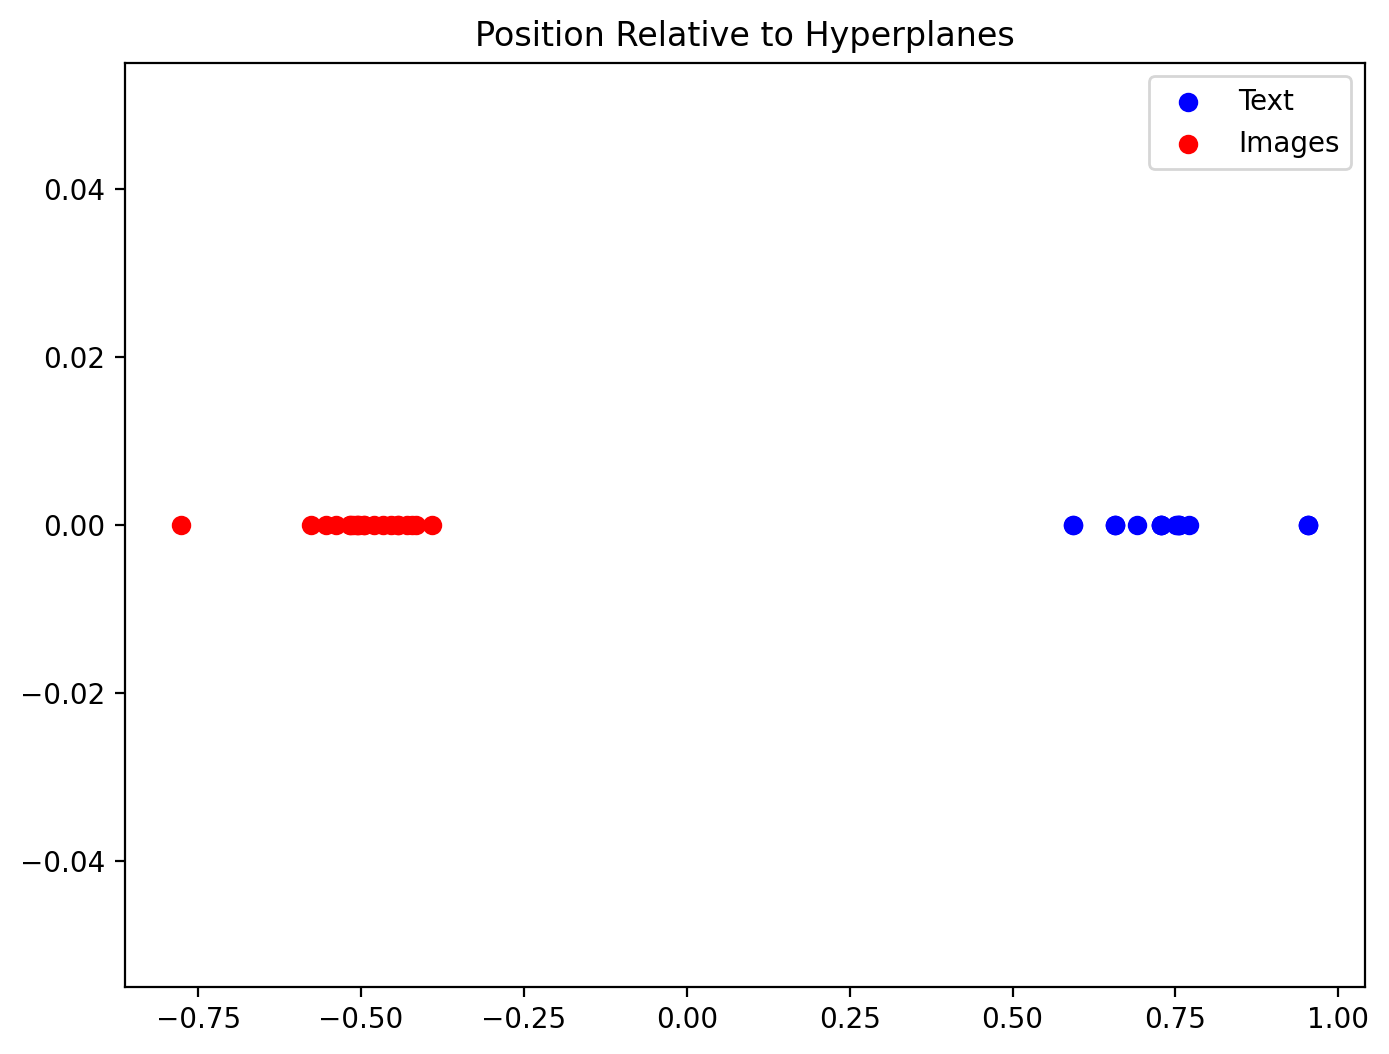

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# Plot class 1 data in blue
plt.scatter(predicted_text, np.zeros_like(predicted_text), color='blue', label='Text')

# Plot class 2 data in red
plt.scatter(predicted_image, np.zeros_like(predicted_image), color='red', label='Images')

# Customize the plot (optional)
plt.title('Position Relative to Hyperplanes')
plt.legend()

# Show the plot
plt.show()

In [100]:
print(predicted_image[:5])
print(predicted_text[:5])

[-0.57607815 -0.47999195 -0.51638818 -0.50295849 -0.53779224]
[0.95399578 0.65689428 0.72809336 0.69070076 0.75531897]


In [101]:
classifier.intercept_

array([0.])